In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception

import zipfile
import requests
from io import BytesIO
import pandas as pd

In [11]:
# Definir la función train_df
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        if os.path.isdir(label_dir):  # Asegurarse de que es un directorio
            label = os.listdir(label_dir)
            for image in label:
                image_path = os.path.join(label_dir, image)
                class_paths.append(image_path)
                classes.append(file)  # Aquí corregimos para usar el nombre del archivo como clase
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    
    return tr_df

In [15]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [14]:
tr_df = train_df('./Dataset/train')
tr_df

,Class Path,Class
0,./Dataset/train\Dark\dark (1).png,Dark
1,./Dataset/train\Dark\dark (10).png,Dark
2,./Dataset/train\Dark\dark (100).png,Dark
3,./Dataset/train\Dark\dark (101).png,Dark
4,./Dataset/train\Dark\dark (102).png,Dark
...,...,...
1035,./Dataset/train\Medium\medium (95).png,Medium
1036,./Dataset/train\Medium\medium (96).png,Medium
1037,./Dataset/train\Medium\medium (97).png,Medium
1038,./Dataset/train\Medium\medium (98).png,Medium


In [16]:
ts_df = test_df('./Dataset/test')
ts_df

,Class Path,Class
0,./Dataset/test\Dark\dark (1).png,Dark
1,./Dataset/test\Dark\dark (10).png,Dark
2,./Dataset/test\Dark\dark (100).png,Dark
3,./Dataset/test\Dark\dark (11).png,Dark
4,./Dataset/test\Dark\dark (12).png,Dark
...,...,...
395,./Dataset/test\Medium\medium (95).png,Medium
396,./Dataset/test\Medium\medium (96).png,Medium
397,./Dataset/test\Medium\medium (97).png,Medium
398,./Dataset/test\Medium\medium (98).png,Medium


In [33]:
def plot_class_distribution(df):
    """
    Muestra un gráfico de barras de la distribución de clases en un DataFrame.

    Args:
    df (pd.DataFrame): DataFrame que contiene las clases de las imágenes.
    """
    plt.figure(figsize=(15,7))
    ax = sns.countplot(data=df, y='Class', hue='Class', palette='viridis', dodge=False)

    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.xlabel('')
    plt.ylabel('')
    plt.title('Count of images in each class', fontsize=20)

    for container in ax.containers:
        ax.bar_label(container, label_type='edge', padding=10)

    plt.show()

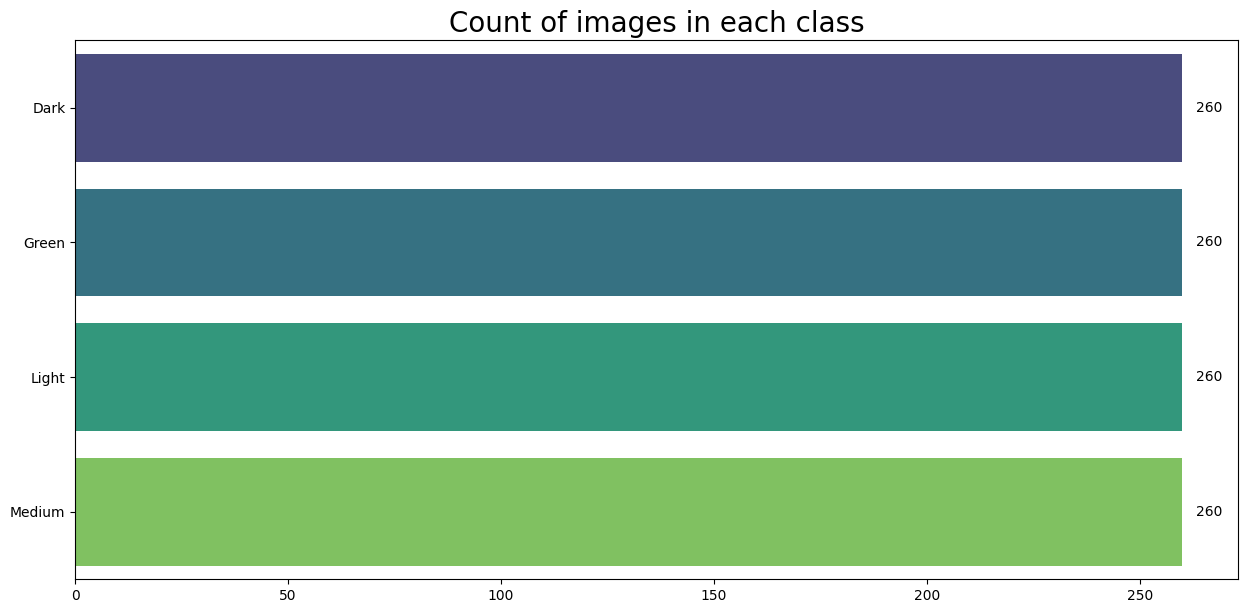

In [34]:
plot_class_distribution(tr_df)

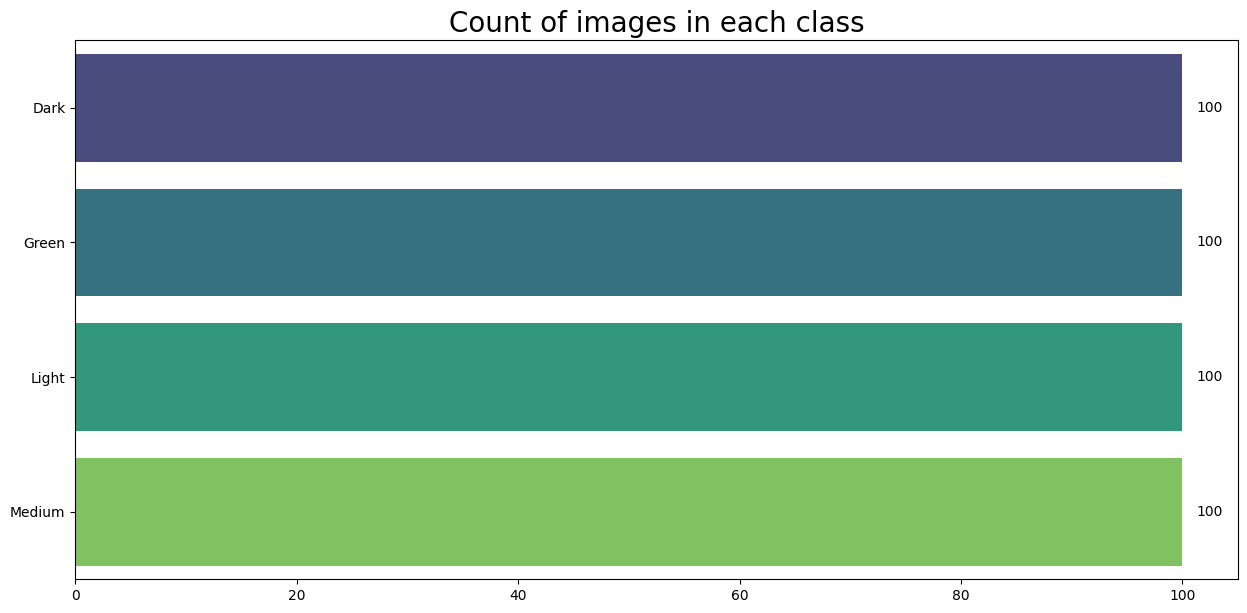

In [35]:
plot_class_distribution(ts_df)

In [36]:
valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)

In [37]:
valid_df

,Class Path,Class
345,./Dataset/test\Medium\medium (5).png,Medium
399,./Dataset/test\Medium\medium (99).png,Medium
330,./Dataset/test\Medium\medium (36).png,Medium
238,./Dataset/test\Light\light (43).png,Light
293,./Dataset/test\Light\light (93).png,Light
...,...,...
393,./Dataset/test\Medium\medium (93).png,Medium
218,./Dataset/test\Light\light (25).png,Light
223,./Dataset/test\Light\light (3).png,Light
271,./Dataset/test\Light\light (73).png,Light


In [38]:
ts_df

,Class Path,Class
10,./Dataset/test\Dark\dark (18).png,Dark
382,./Dataset/test\Medium\medium (83).png,Medium
374,./Dataset/test\Medium\medium (76).png,Medium
196,./Dataset/test\Green\green (96).png,Green
47,./Dataset/test\Dark\dark (51).png,Dark
...,...,...
66,./Dataset/test\Dark\dark (69).png,Dark
281,./Dataset/test\Light\light (82).png,Light
44,./Dataset/test\Dark\dark (49).png,Dark
80,./Dataset/test\Dark\dark (81).png,Dark


In [39]:
batch_size = 16
img_size = (224,224)

tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))

gen = ImageDataGenerator()


tr_gen = tr_gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                 y_col='Class',batch_size=batch_size,
                                 target_size=img_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class',batch_size=batch_size,
                                    target_size=img_size)

ts_gen = gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                y_col='Class',batch_size=batch_size,
                                 target_size=img_size,shuffle=False)

Found 1040 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


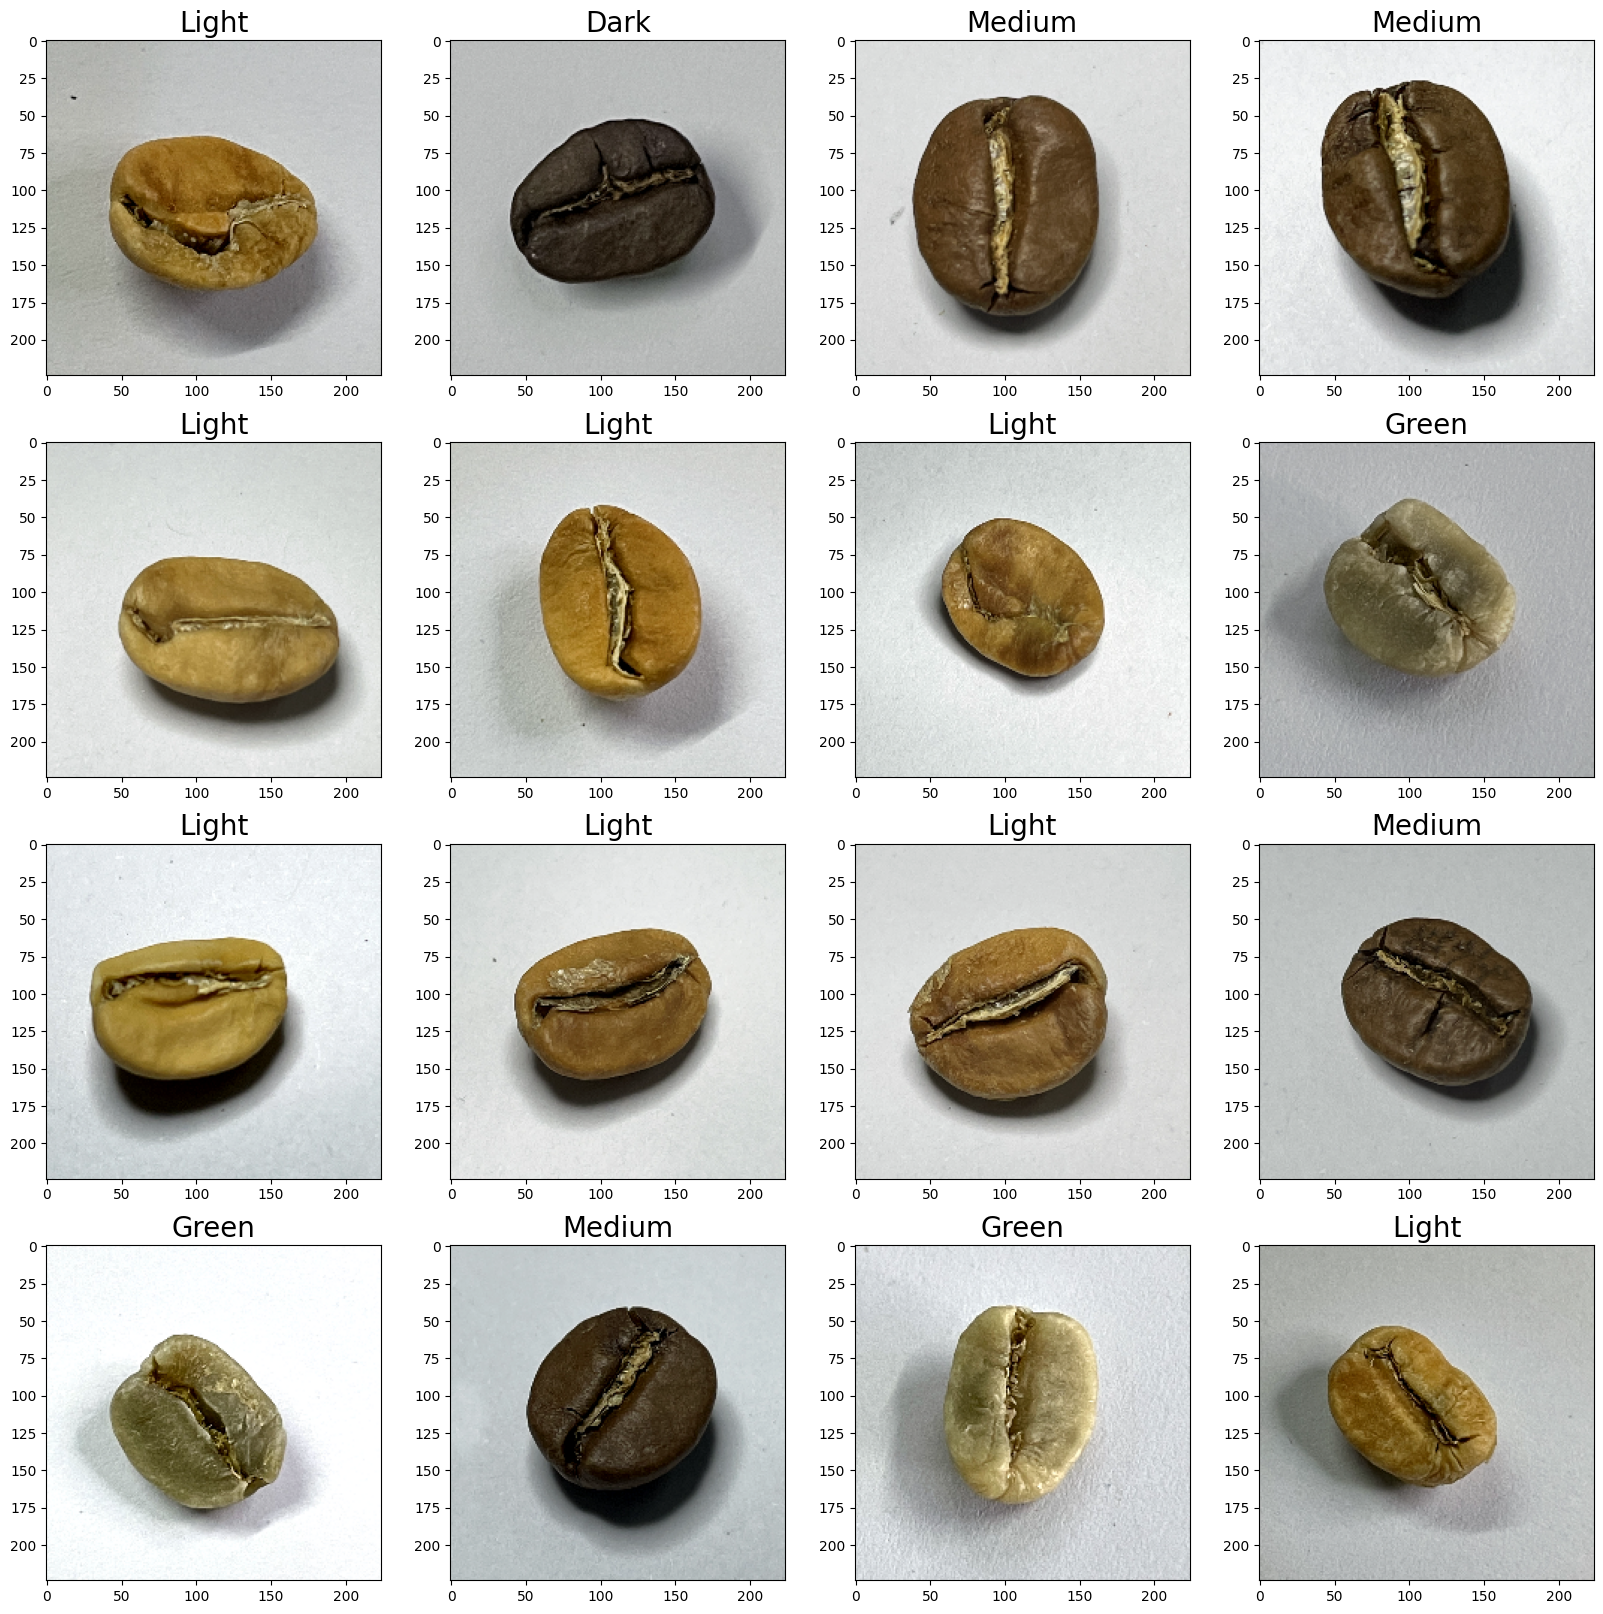

In [40]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
plt.show()

In [41]:
num_classes = len(classes)
num_classes

4

In [59]:
# Crear el modelo base
base_model = Xception(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling=None)

# Añadir capas adicionales
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Asegúrate de no entrenar el modelo base
x = Flatten()(x)  # Aplanar las salidas del modelo base
x = Dense(128, activation='relu')(x)  # Opcional: Capa densa adicional
outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,707,180 (128.58 MB)

 Trainable params: 33,652,652 (128.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [61]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [62]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=3)
hist = model.fit(tr_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=es)

Epoch 1/5


c:\Sevann\UBA\vision_computadora_II\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 540s 8s/step - accuracy: 0.4230 - loss: 2.3967 - val_accuracy: 0.8000 - val_loss: 0.4600
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 486s 7s/step - accuracy: 0.9195 - loss: 0.2234 - val_accuracy: 0.9400 - val_loss: 0.2102
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 416s 6s/step - accuracy: 0.9760 - loss: 0.0764 - val_accuracy: 0.9850 - val_loss: 0.0554
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 427s 7s/step - accuracy: 0.9801 - loss: 0.0551 - val_accuracy: 0.9750 - val_loss: 0.0703
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 429s 7s/step - accuracy: 0.9915 - loss: 0.0265 - val_accuracy: 1.0000 - val_loss: 8.7961e-04


In [63]:
model.evaluate(ts_gen, verbose=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 867ms/step - accuracy: 1.0000 - loss: 0.0025


[0.004419274162501097, 1.0]

In [64]:
model.save("coffee_Model.h5")

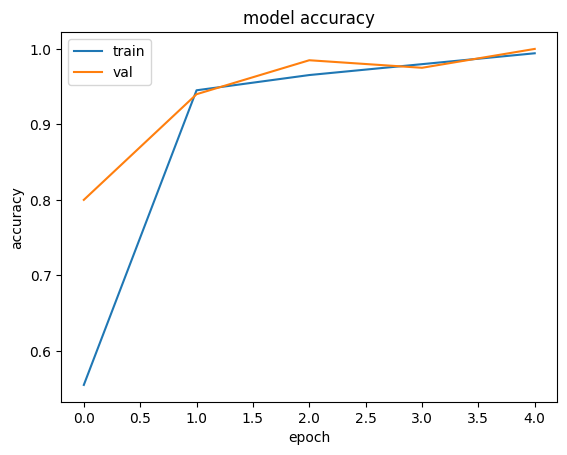

In [65]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

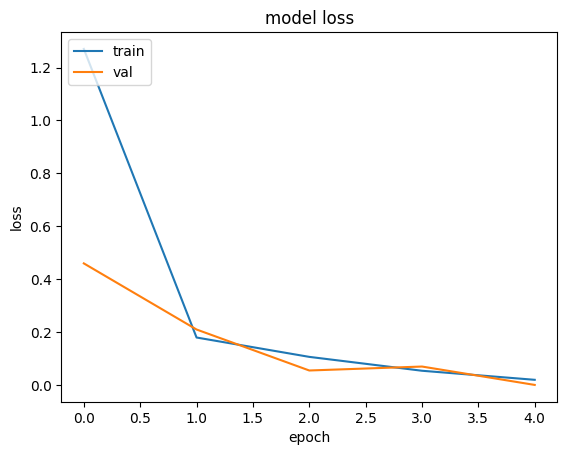

In [66]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
pred = model.predict(ts_gen)
pred = np.argmax(pred, axis=1)

labels = (tr_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 805ms/step


In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = ts_df['Class']
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00        57
       Green       1.00      1.00      1.00        47
       Light       1.00      1.00      1.00        39
      Medium       1.00      1.00      1.00        57

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy of the Model: 100.0%


In [69]:
classes=list(tr_gen.class_indices.keys())
print (classes)

['Dark', 'Green', 'Light', 'Medium']


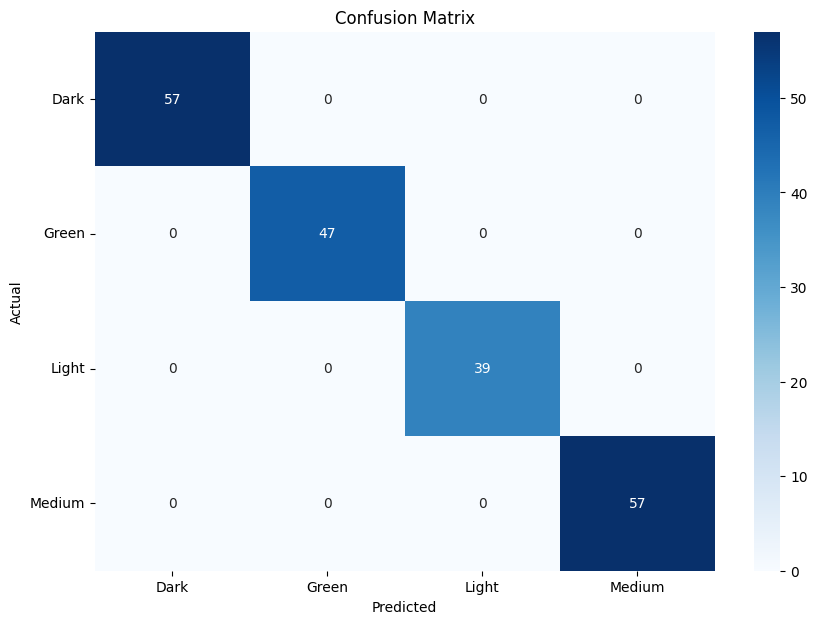

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = ts_df['Class'].values  # Replace 'Class' with the actual column name containing the true labels
cm = confusion_matrix(y_true, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

num_classes = len(classes)

plt.xticks(ticks=[i + 0.5 for i in range(num_classes)], labels=classes, rotation=0)
plt.yticks(ticks=[i + 0.5 for i in range(num_classes)], labels=classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()